In [ ]:
# !pip install transformers torch huggingface_hub

In [ ]:
!pip install pyexiv2 peft

In [ ]:
# !pip install git+https://github.com/huggingface/diffusers

In [ ]:
!pip install diffusers

In [ ]:
from diffusers import(
    StableDiffusionPipeline,
    DPMSolverMultistepScheduler,
    AutoencoderKL,
)
import transformers
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from huggingface_hub import hf_hub_download,login
import gc

For Private Huggingface Model

In [ ]:
login(token="your_token")

Model Download Civit Ai

Pruned MeinaMixV12 FP16

In [ ]:
# !curl -L -o model.safetensors -H "Authorization: Bearer civit_ai_token" "https://civitai.com/api/download/models/9485

Repo Huggingface



In [ ]:
checkpoint_repo = "nqzfaizal77ai/austersight-exp-sd-1.5"

In [ ]:
checkpoint_repo = "finnstrom3693/aingd-v8-sd-1.5"

Lora Download HuggingFace

In [ ]:
lora_repo = "nqzfaizal77ai/sibear-sd-1.5-lora"

In [ ]:
lora_repo = "nqzfaizal77ai/busipa-sd-1.5-lora"

Lora Download From Other Source as File

In [ ]:
# lora_path = "/content"

Load Model

In [ ]:
# model = "/content/model.safetensors"

In [ ]:
precision = 'half' # @param ["half", "full" ,"bf16"]
if precision == "half":
    selected_precision = torch.float16
elif precision == "full":
    selected_precision = torch.float32
elif precision == "bf16":
    selected_precision = torch.bfloat16

Load Model From File

In [ ]:
# pipe = StableDiffusionPipeline.from_single_file(model,
#                                             torch_dtype=selected_precision,
#                                             use_safetensors=True)

Load Model From Huggingface

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(checkpoint_repo,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
pipe.to(device)
pipe.safety_checker = None
pipe.requires_safety_checker = False
DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    algorithm_type="sde-dpmsolver++",
    use_karras_sigmas=True
)

Load Lora Model

In [ ]:
# pipe.load_lora_weights(lora_repo,weight_name="sidebangs-hairstyle-plus-earring-10.safetensors")

In [ ]:
pipe.load_lora_weights(lora_repo,weight_name="pytorch_lora_weights.safetensors")

In [ ]:
#pipe.load_lora_weights(lora_path,weight_name="pytorch_lora_weights.safetensors")

In [ ]:
lora_weight="1" # @param ["1","0.8","1.2"]
lora_weight=float(lora_weight)

In [ ]:
print(pipe.get_list_adapters())

{'unet': ['default_0']}


In [ ]:
pipe.set_adapters("default_0", adapter_weights=lora_weight)

Unload Lora Model

In [ ]:
pipe.unload_lora_weights()

Inference Text to Image Test

In [ ]:
# @title Inference Settings

prompt = "1 girl,busipa,bang under sidepart,long back hair,middle parted hair,upperbody shot,black hair,sweatshirt,skirt,college student,flat anime style,masterpiece,detailed,high quality,anime style garden" # @param {type:"string"}
negative_prompt = "lowres,text,error,cropped,worst quality,low quality,jpeg artifacts,ugly,duplicate,morbid,mutilated,out of frame,extra fingers,mutated hands,poorly drawn hands,poorly drawn face,mutation,deformed,blurry,dehydrated,bad anatomy,bad proportions,extra limbs,cloned face,disfigured,gross proportions,malformed limbs,missing arms,missing legs,extra arms,extra legs,fused fingers,too many fingers,long neck,username,watermark,signature" # @param {type:"string"}
orientation = 'portrait' # @param ["portrait", "square","square-ex","landscape"]
# Set width and height based on orientation
if orientation == 'portrait':
    width = 512 # Example width for portrait
    height = 768 # Example height for portrait
elif orientation == 'square':
    width = 512 # Example width for square
    height = 512 # Example height for
elif orientation == 'square-ex':
    width = 640 # Example width for square
    height = 640 # Example height for square
elif orientation == 'landscape':
    width = 768 # Example width for landscape
    height = 512 # Example height for landscape
size=str(width)+"x"+str(height)
cfg_scale = 9 # @param {type:"integer"}
steps = 20 # @param {type:"integer"}
sampler = "DPM++ SDE Karras" # @param {type:"string"}
modelname = "nqzfaizal77ai/austersight-exp-sd-1.5" # @param {type:"string"}
loraname = "busipa" # @param {type:"string"}

Random

In [ ]:
import random

manual_seed = random.randint(1,9999999)
print("seed :",manual_seed)
generator = torch.Generator(device=device).manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 4,
            generator = generator
        ).images

seed : 8728111


  0%|          | 0/20 [00:00<?, ?it/s]

Fixed

In [ ]:
manual_seed = 4766553
print("seed :",manual_seed)
generator = torch.Generator(device=device).manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 4,
            generator = generator
        ).images

Show Image

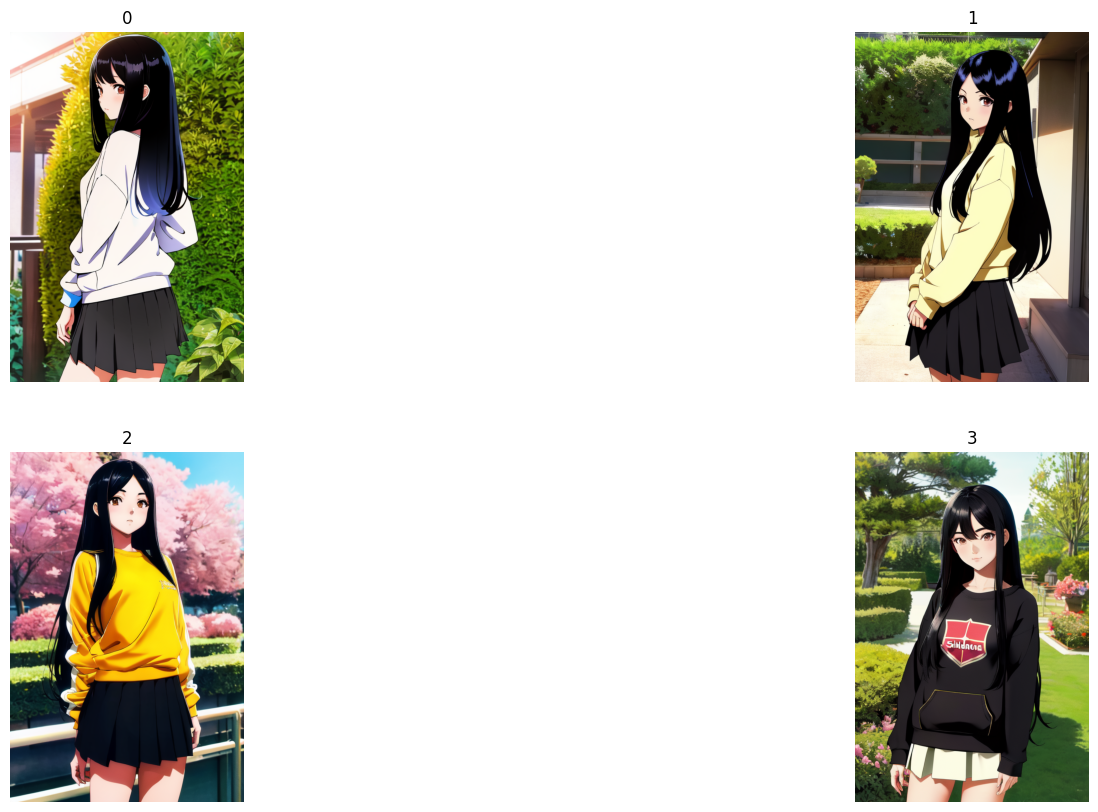

In [ ]:
def plot_images(images):
    N = len(images)
    n_cols = 2
    n_rows = int(np.ceil(N / n_cols))

    plt.figure(figsize = (20, 5 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(i)
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()
plot_images(images)

Save and Write Metadata

In [ ]:
use_lora = "True" # @param ["True","False"]

In [ ]:
import pyexiv2
import json
import os

def get_unique_filename(base_name, ext):
    """Generate a unique filename by appending a numeric suffix if necessary."""
    counter = 1
    unique_name = f"{base_name}{ext}"
    while os.path.exists(unique_name):
        unique_name = f"{base_name}_{counter}{ext}"
        counter += 1
    return unique_name

for i in range(len(images)):
    # Save image with unique filename
    base_filename = f"image{i}"
    ext = ".png"
    unique_filename = get_unique_filename(base_filename, ext)
    images[i].save(unique_filename)

    metadata_diffusers = {
        "prompt": prompt,
        "negativePrompt": negative_prompt,
        "steps": steps,
        "samplerName": sampler,
        "cfgScale": cfg_scale,
        "seed": manual_seed,
        "clipskip": 1,
        "baseModel": "SD 1.5",
        "checkpointModel": modelname,
        "seed": manual_seed
    }

    if use_lora == "True":
        metadata_diffusers.update({
            "loraWeight": lora_weight,
            "loraModel": loraname
        })

    new_metadata = {
        "Exif.Photo.UserComment": metadata_diffusers
    }

    img = pyexiv2.Image(unique_filename)
    img.modify_exif(new_metadata)

# Save metadata to a text file with a unique name
metadata_filename_base = "metadata"
metadata_filename_ext = ".txt"
unique_metadata_filename = get_unique_filename(metadata_filename_base, metadata_filename_ext)
with open(unique_metadata_filename, 'w') as f:
    f.write(json.dumps(metadata_diffusers, indent=4))

Clean GPU

In [ ]:
import torch
import gc

# Delete any references to tensors stored in GPU
del pipe
del generator
# Add any other variables you have here

# Collect garbage to free up memory
gc.collect()

# Empty the CUDA cache
torch.cuda.empty_cache()

Zip Generated File

In [ ]:
import os
import zipfile

def zip_txt_and_png(directory, zip_name):
    try:
        # Create a ZipFile object
        with zipfile.ZipFile(zip_name, 'w') as zipf:
            # Walk through the directory
            for root, dirs, files in os.walk(directory):
                for file in files:
                    # Check if the file is a .txt or .png
                    if file.endswith('.txt') or file.endswith('.png'):
                        # Create the full filepath by joining the root and file name
                        file_path = os.path.join(root, file)
                        # Add the file to the zip file
                        zipf.write(file_path, os.path.relpath(file_path, directory))

        print(f'Successfully created {zip_name}')

    except FileNotFoundError:
        print(f'Error: File or directory not found.')

    except PermissionError:
        print(f'Error: Permission denied while accessing files.')

    except Exception as e:
        print(f'An unexpected error occurred: {e}')

# Usage example
directory_to_zip = os.getcwd()
output_zip_file = 'research_test_image.zip'
zip_txt_and_png(directory_to_zip, output_zip_file)

Successfully created research_test_image.zip


Check Metadata

In [ ]:
# img = pyexiv2.Image(r'image0.png')
# data = img.read_exif()
# print(data)